In [1]:
import psycopg2
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)
import matplotlib
import warnings
import yellowbrick as yb

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier

from yellowbrick.classifier import ClassificationReport

warnings.simplefilter(action='ignore', category=FutureWarning)

/Users/lisahuynh/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
conn = psycopg2.connect( 
                        host = 'project.cgxhdwn5zb5t.us-east-1.rds.amazonaws.com',
                        port = 5432, 
                        user = 'postgres',
                        password = 'Admin123',
                        database = 'postgres')
cursor = conn.cursor()

In [3]:
DEC2FLOAT = psycopg2.extensions.new_type(
    psycopg2.extensions.DECIMAL.values,
    'DEC2FLOAT',
    lambda value, curs: float(value) if value is not None else None)
psycopg2.extensions.register_type(DEC2FLOAT)

In [4]:
cursor.execute('Select * from "ahshouseholdclass2"')
rows = cursor.fetchall()
col_names = []
for elt in cursor.description:
    col_names.append(elt[0])

df = pd.DataFrame(data=rows, columns=col_names )

In [5]:
df.columns

Index(['index', 'CONTROL', 'YEAR', 'RATINGHS_BIN', 'BEDROOMS', 'STORIES',
       'PERPOVLVL', 'HHADLTKIDS', 'HINCP', 'UNITSIZE', 'NUMVETS', 'LOTSIZE',
       'UFINROOMS', 'HHAGE', 'PARTNER', 'OTHERAMT', 'KITCHENS', 'NUMSECFAM',
       'OILAMT', 'DINING', 'FINCP', 'NUMELDERS', 'WATERAMT', 'GASAMT',
       'TOTROOMS', 'HHYNGKIDS', 'NUMSUBFAM', 'BATHROOMS', 'NUMYNGKIDS',
       'TRASHAMT', 'NUMOLDKIDS', 'NUMNONREL', 'NUMPEOPLE', 'HHMOVE', 'UTILAMT',
       'ELECAMT', 'NUMADULTS', 'MULTIGEN', 'LAUNDY', 'HHOLDKIDS', 'FINROOMS',
       'LN_HINCP', 'LN_FINCP', 'HINCP_BIN', 'FINCP_BIN', 'NUMCARE', 'NUMWALK',
       'HHRACE', 'OMB13CBSA', 'HSHLDTYPE', 'MVG3COST', 'MVG2COST', 'MILHH',
       'HHMAR', 'HHNATVTY', 'COOKFUEL', 'NUMMEMRY', 'NUMERRND', 'NUMSEE',
       'BLD', 'NUMHEAR', 'MVG1COST', 'DIVISION', 'FIREPLACE', 'CONDO',
       'OWNLOT', 'FRIDGE', 'FIRSTHOME', 'HHCARE', 'NOSTEP', 'WASHER', 'HHSEE',
       'KITCHSINK', 'HHERRND', 'WINBARS', 'HHWALK', 'HHHEAR', 'HHSEX',
       'HHMEMRY', 'GA

In [6]:
df['HINCP_BIN'].value_counts()


(40000.0, 50000.0]     2465
(30000.0, 40000.0]     2409
(20000.0, 30000.0]     2403
(50000.0, 60000.0]     2220
(60000.0, 70000.0]     2011
(10000.0, 20000.0]     2003
(70000.0, 80000.0]     1956
(80000.0, 90000.0]     1737
(90000.0, 100000.0]    1558
(0.0, 10000.0]         1346
Name: HINCP_BIN, dtype: int64

In [7]:
df['FINCP_BIN'].value_counts()


(40000.0, 50000.0]     2536
(20000.0, 30000.0]     2529
(30000.0, 40000.0]     2522
(50000.0, 60000.0]     2184
(10000.0, 20000.0]     2125
(60000.0, 70000.0]     1899
(70000.0, 80000.0]     1846
(80000.0, 90000.0]     1582
(0.0, 10000.0]         1451
(90000.0, 100000.0]    1434
Name: FINCP_BIN, dtype: int64

In [8]:
df['RATINGHS_BIN'].value_counts()


extremely satisfied    7021
satisfied              5284
not satisfied          4887
very satisfied         2916
Name: RATINGHS_BIN, dtype: int64

In [9]:
df.head(10)

,index,CONTROL,YEAR,RATINGHS_BIN,BEDROOMS,STORIES,PERPOVLVL,HHADLTKIDS,HINCP,UNITSIZE,...,HHSEE,KITCHSINK,HHERRND,WINBARS,HHWALK,HHHEAR,HHSEX,HHMEMRY,GARAGE,DISHWASH
0,0,11000006,2017,extremely satisfied,3.0,1.0,361.0,0.0,58700.0,4.0,...,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0
1,1,11000023,2017,satisfied,3.0,3.0,501.0,0.0,100000.0,4.0,...,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0
2,2,11000046,2017,extremely satisfied,3.0,1.0,52.0,0.0,15000.0,2.0,...,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0
3,3,11000048,2017,very satisfied,4.0,3.0,406.0,0.0,100000.0,6.0,...,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0
4,4,11000052,2017,not satisfied,4.0,2.0,113.0,0.0,13200.0,3.0,...,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0
5,5,11000054,2017,satisfied,2.0,7.0,501.0,0.0,71004.0,3.0,...,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0
6,6,11000062,2017,not satisfied,2.0,1.0,104.0,0.0,30200.0,4.0,...,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0
7,7,11000066,2017,not satisfied,2.0,1.0,117.0,1.0,29000.0,3.0,...,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
8,8,11000067,2017,satisfied,2.0,1.0,198.0,0.0,25000.0,3.0,...,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
9,9,11000079,2017,satisfied,2.0,2.0,302.0,0.0,59000.0,5.0,...,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0


In [10]:
LABEL_MAP = {
"(90000.0, 100000.0]": 10,
"(80000.0, 90000.0]": 9,
"(70000.0, 80000.0]": 8,   
"(60000.0, 70000.0]": 7,
"(50000.0, 60000.0]": 6,
"(40000.0, 50000.0]": 5,
"(30000.0, 40000.0]": 4,
"(20000.0, 30000.0]": 3,
"(10000.0, 20000.0]": 2,
"(0.0, 10000.0]": 1}

# Convert categorical labels into incremental value
df['HINCP_BIN'] = df['HINCP_BIN'].map(LABEL_MAP).to_frame()

In [11]:
LABEL_MAP = {
"(90000.0, 100000.0]": 10,
"(80000.0, 90000.0]": 9,
"(70000.0, 80000.0]": 8,   
"(60000.0, 70000.0]": 7,
"(50000.0, 60000.0]": 6,
"(40000.0, 50000.0]": 5,
"(30000.0, 40000.0]": 4,
"(20000.0, 30000.0]": 3,
"(10000.0, 20000.0]": 2,
"(0.0, 10000.0]": 1}

# Convert categorical labels into incremental value
df['FINCP_BIN'] = df['FINCP_BIN'].map(LABEL_MAP).to_frame()

In [12]:
df['HINCP_BIN'].head(10)

0     6
1    10
2     2
3    10
4     2
5     8
6     4
7     3
8     3
9     6
Name: HINCP_BIN, dtype: int64

In [13]:
df['FINCP_BIN'].head(10)

0     6
1    10
2     2
3    10
4     2
5     8
6     4
7     3
8     3
9     4
Name: FINCP_BIN, dtype: int64

In [14]:
df['FINCP_BIN'].dtypes

dtype('int64')

### Class Balanced

In [15]:
# Create the train and test data
from sklearn.model_selection import train_test_split

X = df.loc[:, df.columns.difference(['CONTROL', 'YEAR', 'RATINGHS_BIN'])] 
y = df.iloc[:,3]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

In [16]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 33)

In [17]:
X_sm, y_sm = sm.fit_sample(X, y)


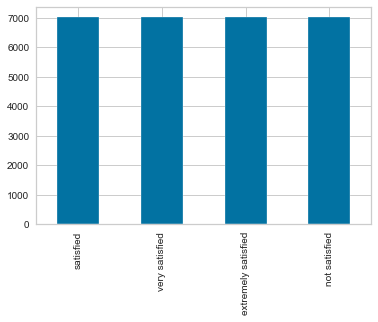

In [18]:
X_sm, y_sm = sm.fit_sample(X_sm, y_sm.ravel())
pd.Series(y_sm).value_counts().plot.bar()

In [26]:
def score_model(X, y, estimator, **kwargs):

    y = LabelEncoder().fit_transform(y)

    model = Pipeline([
         ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore')), 
         ('estimator', estimator)
    ])

    model.fit(X_train, y_train, **kwargs)  
    
    expected  = y_test
    predicted = model.predict(X_test)
    
    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted, average='micro')))

In [29]:
models = [
    SVC(), NuSVC(), LinearSVC(), 
    SGDClassifier(), KNeighborsClassifier(), 
    LogisticRegression(), 
    #aggingClassifier(), 
    ExtraTreesClassifier(n_estimators=100), 
    RandomForestClassifier(n_estimators=100),
    GradientBoostingClassifier(n_estimators=100,learning_rate=.3)
    #learning_rate=.5,max_depth=4, min_samples_leaf=75
]

for model in models:
    score_model(X_sm, y_sm, model)

SVC: 0.37767279960218797
NuSVC: 0.35131775236200896


/Users/lisahuynh/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC: 0.3488314271506713
SGDClassifier: 0.35778219791148685
KNeighborsClassifier: 0.3431128791645947


/Users/lisahuynh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression: 0.3446046742913973
ExtraTreesClassifier: 0.38015912481352554
RandomForestClassifier: 0.38637493784186977
GradientBoostingClassifier: 0.374440576827449


## GridSearchCV

In [30]:
RandomForestClassifier().get_params()


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [36]:
from sklearn.model_selection import GridSearchCV
model = RandomForestClassifier()

# TODO:  Create a dictionary with the Ridge parameter options
parameters = {'bootstrap': [True, False],
              #'ccp_alpha': [0.0],
              #'class_weight': [None],
              'criterion': ['gini','entropy'],
              'max_depth': [10,25,50],
              'max_features': ['auto','sqrt','log2'],
              #'max_leaf_nodes': [None],
              #'max_samples': [None],
              #'min_impurity_split': [None],
              'min_samples_leaf': [1,2,4],
              'min_samples_split': [2,5,10],
              #'min_weight_fraction_leaf': [0.0],
              'n_estimators': [50,100],
              #'n_jobs': [None],
              #'oob_score': [True, False],
              'random_state': [None, 2, 6, 7, 8],
              #'verbose': [0],
              'warm_start': [True, False]}

clf = GridSearchCV(model, parameters, cv=5)
clf.fit(X_train, y_train)

print('If we change our parameters to: {}'.format(clf.best_params_))

KeyboardInterrupt: 

In [35]:
RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])